Dieses Notebook erstellt einen weiteren Random Forest mit allen Features und balanced class weight. Anschließend wird mit diesem Setting eine Hyperparameter Grid Search durchgeführt.

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from utils.training import train_random_forest, predict_random_forest
import joblib
from datetime import datetime

feature_file = "./features/features.hdf5"
data_split_file = "./data_split.yaml"
features = ['mean', 'variance', 'std', 'ptp_amp', 'skewness', 'kurtosis', 'quantile', 'pow_freq_bands', 'hurst_exp',
'decorr_time', 'line_length', 'rms', 'higuchi_fd', 'spect_entropy', 'svd_entropy', 'teager_kaiser_energy',
'wavelet_coef_energy', 'zero_crossings', 'app_entropy']
model_save_path = f'./models/{datetime.now().strftime('%d-%m-%y %H-%M-%S')}.joblib'
random_state = 42

clf = RandomForestClassifier(n_jobs=-1, verbose=1, random_state=random_state, class_weight='balanced')

clf = train_random_forest(clf, feature_file, features, data_split_file)
joblib.dump(clf, model_save_path)

y_true_train, y_pred_train = predict_random_forest(clf, feature_file, features, data_split_file, 'train')
y_true_val, y_pred_val = predict_random_forest(clf, feature_file, features, data_split_file, 'val')
print(f'Classifiction report training set \n\n{classification_report(y_true_train, y_pred_train, target_names=["Kein Artefakt", "Artefakt"])}\n\n')
print(f'Classifiction report validtation set \n\n{classification_report(y_true_val, y_pred_val, target_names=["Kein Artefakt", "Artefakt"])}')

Extracting features and labels for sessions:   0%|          | 0/268 [00:00<?, ?it/s]

Extracting features and labels for sessions: 100%|██████████| 268/268 [00:13<00:00, 19.36it/s]
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of 100 | elapsed:  2.2min remaining: 19.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.8min finished
Extracting features and labels for sessions: 100%|██████████| 268/268 [00:13<00:00, 19.45it/s]
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  10 out of 100 | elapsed:    3.1s remaining:   28.1s
[Parallel(n_jobs=96)]: Done 100 out of 100 | elapsed:    5.6s finished
Extracting features and labels for sessions: 100%|██████████| 268/268 [00:04<00:00, 64.94it/s] 
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done  10 out of 100 | elapsed:    0.9s remaining:    8.2s
[Parallel(n_jobs=96)]: Done 100 out of 100 | elapsed:    1.7s finished


Classifiction report training set 

               precision    recall  f1-score   support

Kein Artefakt       1.00      1.00      1.00   3367153
     Artefakt       1.00      1.00      1.00    811909

     accuracy                           1.00   4179062
    macro avg       1.00      1.00      1.00   4179062
 weighted avg       1.00      1.00      1.00   4179062



Classifiction report validtation set 

               precision    recall  f1-score   support

Kein Artefakt       0.90      0.93      0.92    971776
     Artefakt       0.63      0.54      0.58    210350

     accuracy                           0.86   1182126
    macro avg       0.77      0.74      0.75   1182126
 weighted avg       0.86      0.86      0.86   1182126



Der Score auf dem Validationset ist für Keine Artefakte besser geworden, für Artefakte jedoch schlechter. Das könnte für zu viele Features sprechen. Da das Training mit wachsender Feature Zahl länger dauert, werden für die GridSearch die 9 hinzugefügten Features wieder weggelassen. Anschließend wird für die Kombination aus Parametern eine Evaluation durchgeführt.

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from utils.training import get_features_and_labels
from sklearn.metrics import classification_report
import joblib
from datetime import datetime

random_state = 42
feature_file = "./features/features_no_hp.hdf5"
split_train = 'train'
data_split_file = "./data_split.yaml"
features = ['mean', 'variance', 'std', 'ptp_amp', 'skewness', 'kurtosis', 'quantile', 'pow_freq_bands', 'hurst_exp', 'decorr_time']
model_save_path = f'./models/{datetime.now().strftime('%d-%m-%y %H-%M-%S')}.joblib'

params = {
    'max_depth': [5, 10, 20, 30, None],
    'max_features': ['sqrt', 'log2', 2, 4, 6, 8]
}

X_train, y_train = get_features_and_labels(feature_file, features, split_train, data_split_file)

clf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
cv_splitter = StratifiedKFold(5, shuffle=True, random_state=42)
gcv = GridSearchCV(clf, params, cv=cv_splitter, scoring='f1_macro', n_jobs=1, verbose=1, return_train_score=True)

gcv.fit(X_train, y_train)

df = pd.DataFrame(gcv.cv_results_)
df.to_csv('output/exp_03_06_cv_results_no_hp.csv', index=False)

joblib.dump(gcv.best_estimator_, model_save_path)

Extracting features and labels for sessions: 100%|██████████| 268/268 [00:02<00:00, 124.44it/s]


Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [23]:
import pandas as pd

df = pd.read_csv('output/exp_03_06_cv_results_no_hp.csv')
df.loc[df['mean_test_score'].idxmax()]

mean_fit_time                                    63.744426
std_fit_time                                      2.082454
mean_score_time                                   1.379853
std_score_time                                    0.056777
param_max_depth                                       30.0
param_max_features                                       2
params                {'max_depth': 30, 'max_features': 2}
split0_test_score                                 0.820924
split1_test_score                                 0.819882
split2_test_score                                 0.819826
split3_test_score                                  0.82059
split4_test_score                                 0.820251
mean_test_score                                   0.820295
std_test_score                                    0.000419
rank_test_score                                          1
split0_train_score                                0.976991
split1_train_score                                0.9767

In [21]:
import pandas as pd

df = pd.read_csv('output/exp_03_06_cv_results_no_hp.csv')
df[['params', 'mean_test_score', 'mean_train_score']]

,params,mean_test_score,mean_train_score
0,"{'max_depth': 5, 'max_features': 'sqrt'}",0.785500,0.785638
1,"{'max_depth': 5, 'max_features': 'log2'}",0.785500,0.785638
2,"{'max_depth': 5, 'max_features': 2}",0.783484,0.783611
3,"{'max_depth': 5, 'max_features': 4}",0.785454,0.785574
4,"{'max_depth': 5, 'max_features': 6}",0.783674,0.783768
5,"{'max_depth': 5, 'max_features': 8}",0.782813,0.782888
6,"{'max_depth': 10, 'max_features': 'sqrt'}",0.791406,0.792957
7,"{'max_depth': 10, 'max_features': 'log2'}",0.791406,0.792957
8,"{'max_depth': 10, 'max_features': 2}",0.791114,0.792480
9,"{'max_depth': 10, 'max_features': 4}",0.791103,0.792775


Nun wird der beste Estimator noch auf dem Validierungsset ausgewertet. Einmal mit einem Classification report und einmal mit IoU.

In [4]:
import joblib
from utils.training import get_features_and_labels
from sklearn.metrics import classification_report


split_val = 'val'
feature_file = "./features/features_no_hp.hdf5"
split_val = 'val'
data_split_file = "./data_split.yaml"
features = ['mean', 'variance', 'std', 'ptp_amp', 'skewness', 'kurtosis', 'quantile', 'pow_freq_bands', 'hurst_exp', 'decorr_time']

clf = joblib.load('models/15-11-25 21-17-01.joblib')

X_val, y_val = get_features_and_labels(feature_file, features, split_val, data_split_file)
y_pred = clf.predict(X_val)
print(f'Classifiction report validtation set \n\n{classification_report(y_val, y_pred, target_names=["Kein Artefakt", "Artefakt"])}')

Extracting features and labels for sessions: 100%|██████████| 268/268 [00:00<00:00, 278.35it/s]


Classifiction report validtation set 

               precision    recall  f1-score   support

Kein Artefakt       0.92      0.90      0.91    971776
     Artefakt       0.58      0.62      0.60    210350

     accuracy                           0.85   1182126
    macro avg       0.75      0.76      0.76   1182126
 weighted avg       0.86      0.85      0.86   1182126



In [10]:
import joblib
from utils.training import predict_random_forest
from utils.evaluation import get_iou_for_set
import numpy as np
import matplotlib.pyplot as plt

feature_file = "./features/features_no_hp.hdf5"
data_split_file = "./data_split.yaml"
features = ['mean', 'variance', 'std', 'ptp_amp', 'skewness', 'kurtosis', 'quantile', 'pow_freq_bands', 'hurst_exp', 'decorr_time']
random_state = 42
overlap_treshold_values = np.linspace(0, 1, num = 21)

precision_values_val = []
recall_values_val = []
f1_values_val = []

clf = joblib.load('models/15-11-25 21-17-01.joblib')

_, y_pred_val = predict_random_forest(clf, feature_file, features, data_split_file, 'val')

for overlap_treshold in overlap_treshold_values:
    precision_val, recall_val, f1_val = get_iou_for_set(overlap_treshold, y_pred_val, data_split_file, 'val', feature_file)

    precision_values_val.append(precision_val)
    recall_values_val.append(recall_val)
    f1_values_val.append(f1_val)

Extracting features and labels for sessions: 100%|██████████| 268/268 [00:00<00:00, 337.63it/s]


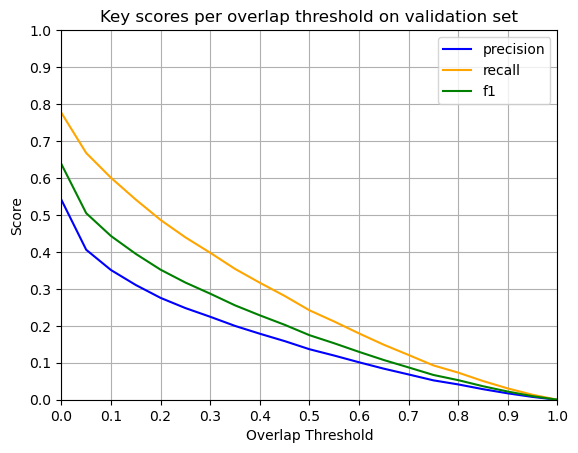

In [11]:
ticks = np.linspace(0, 1, num=11)

plt.xticks(ticks)
plt.yticks(ticks)

plt.plot(overlap_treshold_values, precision_values_val, label='precision', color='blue')
plt.plot(overlap_treshold_values, recall_values_val, label='recall', color='orange')
plt.plot(overlap_treshold_values, f1_values_val, label='f1', color='green')

plt.xlabel('Overlap Threshold')
plt.ylabel('Score')
plt.title('Key scores per overlap threshold on validation set')
plt.grid(True)
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.savefig('output/exp_03_06_iou_f1_val_best_estimator_no_hp.svg')
plt.show()

Nach Vergleich mit dem IoU Plot aus `exp_03_04` zeigt sich, dass der beste Estimator sogar etwas schlechter ist als der Vergleicht im Bezug auf IoU. Wenn man in der CV Results schaut, sieht man, dass die train scores höher sind, je höher `max_depth` ist. Daher trainiere ich nun einen Random Forest mit niedrigerem `max_depth` als der beste Estimator und erhoffe mir dadurch bessere Generalisierung auf dem Validierungsset.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from utils.training import train_random_forest, predict_random_forest
from sklearn.metrics import classification_report
import joblib
from datetime import datetime

random_state = 42
feature_file = "./features/features_no_hp.hdf5"
split_train = 'train'
data_split_file = "./data_split.yaml"
features = ['mean', 'variance', 'std', 'ptp_amp', 'skewness', 'kurtosis', 'quantile', 'pow_freq_bands', 'hurst_exp', 'decorr_time']
model_save_path = f'./models/{datetime.now().strftime('%d-%m-%y %H-%M-%S')}.joblib'

clf = RandomForestClassifier(n_jobs=-1, max_depth=20, random_state=random_state, class_weight='balanced')

clf = train_random_forest(clf, feature_file, features, data_split_file)
joblib.dump(clf, model_save_path)

y_true_train, y_pred_train = predict_random_forest(clf, feature_file, features, data_split_file, 'train')
y_true_val, y_pred_val = predict_random_forest(clf, feature_file, features, data_split_file, 'val')
print(f'Classifiction report training set \n\n{classification_report(y_true_train, y_pred_train, target_names=["Kein Artefakt", "Artefakt"])}\n\n')
print(f'Classifiction report validtation set \n\n{classification_report(y_true_val, y_pred_val, target_names=["Kein Artefakt", "Artefakt"])}')

Extracting features and labels for sessions: 100%|██████████| 268/268 [00:00<00:00, 329.73it/s]


Classifiction report training set 

               precision    recall  f1-score   support

Kein Artefakt       0.97      0.91      0.94   3367153
     Artefakt       0.71      0.88      0.78    811909

     accuracy                           0.91   4179062
    macro avg       0.84      0.90      0.86   4179062
 weighted avg       0.92      0.91      0.91   4179062



Classifiction report validtation set 

               precision    recall  f1-score   support

Kein Artefakt       0.94      0.85      0.89    971776
     Artefakt       0.52      0.73      0.61    210350

     accuracy                           0.83   1182126
    macro avg       0.73      0.79      0.75   1182126
 weighted avg       0.86      0.83      0.84   1182126



In [16]:
from utils.evaluation import get_iou_for_set

precision_values_val = []
recall_values_val = []
f1_values_val = []
overlap_treshold_values = np.linspace(0, 1, num=21)

for overlap_treshold in overlap_treshold_values:
    precision_val, recall_val, f1_val = get_iou_for_set(overlap_treshold, y_pred_val, data_split_file, 'val', feature_file)

    precision_values_val.append(precision_val)
    recall_values_val.append(recall_val)
    f1_values_val.append(f1_val)

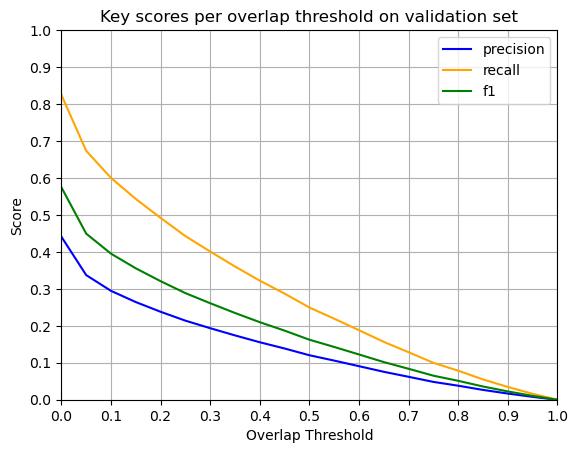

In [17]:
ticks = np.linspace(0, 1, num=11)

plt.xticks(ticks)
plt.yticks(ticks)

plt.plot(overlap_treshold_values, precision_values_val, label='precision', color='blue')
plt.plot(overlap_treshold_values, recall_values_val, label='recall', color='orange')
plt.plot(overlap_treshold_values, f1_values_val, label='f1', color='green')

plt.xlabel('Overlap Threshold')
plt.ylabel('Score')
plt.title('Key scores per overlap threshold on validation set')
plt.grid(True)
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.savefig('output/exp_03_06_iou_f1_val_regularized.svg')
plt.show()